In [1]:
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from oldTrainVoxelmorph import VoxelmorphTF
from DataHandler import DataHandler
import SimpleITK as sitk
import os

In [2]:
def get_moved_points(points: np.array, displacement: sitk.Image) -> np.array:
    displacement_transform = sitk.DisplacementFieldTransform(sitk.Cast(displacement, sitk.sitkVectorFloat64))
    moved_points = [
        displacement_transform.TransformPoint(point) for point in points
    ]
    return moved_points

def get_landmarks(fixed_image_path: str, indexing: str = 'zyx', MR = False) -> (np.array, np.array):
    model_name = os.path.basename(fixed_image_path).replace('_atn_3.nrrd', '')
    # loaded_points = np.load(
    #     f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion/{model_name}_idx.p'
    # )
    if MR: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CTMR_points_t1_t3_withRegion/{model_name}_idx.p', "rb"))
    else: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion/{model_name}_idx.p', "rb"))
    moving_landmarks = np.array(loaded_points['t1'])
    fixed_landmarks = np.array(loaded_points['t3'])
    if indexing == 'zyx':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 2]] = moving_landmarks[:, [2, 0]]
        fixed_landmarks[:, [0, 2]] = fixed_landmarks[:, [2, 0]]
    if indexing == 'yxz':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 1]] = moving_landmarks[:, [1, 0]]
        fixed_landmarks[:, [0, 1]] = fixed_landmarks[:, [1, 0]]
    else:
        assert indexing == 'xyz', f'indexing can only be xyz or zyx. Got: {indexing}'
    return moving_landmarks.astype(np.float64), fixed_landmarks.astype(
        np.float64)

In [3]:
framework = VoxelmorphTF()
dh = DataHandler(val_images=12)
model_path = '/home/cschellenberger/Documents/scripts/models/synthetic/lucavxm/weights.h5'
#model_path = '/home/cschellenberger/Documents/scripts/models/synthetic/vxmtf_CTMRTep200_st100_lr0_001_bat8_final_loss0_0111/weights.h5'
#model_path = '/home/cschellenberger/Documents/scripts/models/synthetic/vxmtf_NCCFullCTMRTep200_st100_lr0_001_bat8_actual_ep163_final_loss-0_5922/weights.h5'
dh.get_synthetic_data(
    fixed_path='/home/cschellenberger/datam2olie/synthetic/orig/t3/Synthetic_CT/',
    moving_path='/home/cschellenberger/datam2olie/synthetic/orig/t1/Synthetic_CT/',
    traverse_sub_dir=False)
moving_image_paths = dh.x_val
fixed_image_paths = dh.y_val
moving_image = sitk.ReadImage(moving_image_paths[0])
fixed_image = sitk.ReadImage(fixed_image_paths[0])
moving_image = sitk.Cast(moving_image, sitk.sitkFloat32)
fixed_image = sitk.Cast(fixed_image, sitk.sitkFloat32)
nb_features = [[16, 32, 32, 32], [32, 32, 32, 32, 32, 16, 16]]
#nb_features = [[16, 16, 32, 32], [32, 32, 16, 16]]
moved_image_np, displacement_np, time = framework.register_images(
        fixed_image=fixed_image,
        moving_image=moving_image,
        weights_path=model_path,
        nb_features=nb_features)


2022-03-07 19:45:08.062815: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-07 19:45:10.148294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 39196 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:1d:00.0, compute capability: 7.5
2022-03-07 19:45:10.150050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46890 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:1e:00.0, compute capability: 7.5
2022-03-07 19:45:10.151205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:G

In [4]:
displacement = displacement_np.squeeze()
displacement[:,:,:,[0,2]] = displacement[:,:,:,[2,0]]
displacement = 1.8 * displacement
moved_image = moved_image_np.squeeze()
moved_image = sitk.GetImageFromArray(moved_image)
displacement = sitk.GetImageFromArray(displacement, isVector=True)
displacement.SetSpacing(fixed_image.GetSpacing())
displacement.SetOrigin(fixed_image.GetOrigin())
displacement.SetDirection(fixed_image.GetDirection())
moved_image.SetSpacing(fixed_image.GetSpacing())
moved_image.SetOrigin(fixed_image.GetOrigin())
moved_image.SetDirection(fixed_image.GetDirection())

In [12]:
from oldTrainVoxelmorph import get_vxm_model
moving_image_np = sitk.GetArrayFromImage(moving_image)[np.newaxis, :]
fixed_image_np = sitk.GetArrayFromImage(fixed_image)[np.newaxis, :]
moved_image_np, displacement_np = get_vxm_model(fixed_image).predict([moving_image_np, fixed_image_np])

2022-03-07 19:43:21.408072: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202
2022-03-07 19:43:21.913624: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [4]:
displacement_np.shape

(1, 128, 256, 256, 3)

In [5]:
def get_moved_image(image: sitk.Image, displacement: sitk.Image) -> np.array:
    resampler = sitk.ResampleImageFilter()
    displacement_transform = sitk.DisplacementFieldTransform(sitk.Cast(displacement,sitk.sitkVectorFloat64))
    resampler.SetReferenceImage(image)
    resampler.SetTransform(displacement_transform)
    return resampler.Execute(image)

In [6]:
from pyM2aia import M2aiaOnlineHelper
fixedDisp = get_moved_image(fixed_image, displacement)
movingDisp = get_moved_image(moving_image, displacement)
M2aiaHelper = M2aiaOnlineHelper("ipynbViewer", "jtfc.de:5050/m2aia/m2aia-no-vnc:with_exit", "8899")
with M2aiaHelper as helper:
    helper.show({"moved": moved_image, "fixedDisp": fixedDisp, "movingDisp": movingDisp, "fixed": fixed_image, "moving": moving_image})
    

You can find your images @  http://141.19.142.80:8899



In [185]:
vector_field_path = "/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion/CT_Model106_Energy110_idx.p"
dic = pickle.load(open(vector_field_path, "rb"))
df = pd.DataFrame()
df['t1X'] = [x[0] for x in dic['t1']]
df['t1Y'] = [x[1] for x in dic['t1']]
df['t1Z'] = [x[2] for x in dic['t1']]
df['t3X'] = [x[0] for x in dic['t3']]
df['t3Y'] = [x[1] for x in dic['t3']]
df['t3Z'] = [x[2] for x in dic['t3']]
df['Region'] = dic['Region']

In [189]:
moving_landmarks, fixed_landmarks = get_landmarks(fixed_image_paths[0], indexing='xyz', MR = False)
moved_landmarks = get_moved_points(fixed_landmarks, displacement)
df['evalX'] = [x[0] for x in moved_landmarks]
df['evalY'] = [x[1] for x in moved_landmarks]
df['evalZ'] = [x[2] for x in moved_landmarks]
print(df.iloc[220])

t1X                              160
t1Y                               77
t1Z                                6
t3X                              160
t3Y                               70
t3Z                               -1
Region    known_vector_chest_surface
evalX                     159.964115
evalY                      73.898271
evalZ                        0.93064
dist                       14.008596
Name: 220, dtype: object


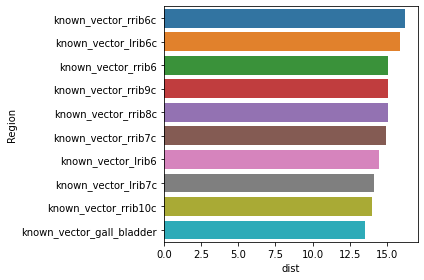

In [190]:
p1 = np.array([df['evalX'], df['evalY'], df['evalZ']])
p2 = np.array([df['t1X'], df['t1Y'], df['t1Z']])
squared_dist = np.sum((p1 - p2) ** 2, axis=0)
df['dist'] = np.sqrt(squared_dist)
dists = df.groupby(df['Region'])['dist'].sum() / df['Region'].value_counts()
dists = dists.sort_values(ascending=False)
ax = sns.barplot(y = df['Region'], x = df['dist'], order = dists.index[:10], errwidth = 0)
plt.tight_layout()
plt.show()


In [191]:
df['dist'].mean()

7.821152317961237